<h1><center> Collaborative Filtering </center></h1>
<h3><center> MSDS 7331: Data Mining </center></h3>
<h4><center> Joe Denney, Sam Coyne, Brian Kolovich, Thomas Wang </center></h4>

# Business Understanding 1

Our dataset derives from a research group called GroupLens Research. GroupLens is a research lab in the Department of Computer Science and Engineering at the University of Minnesota, Twin Cities. GroupLens Research collected and made available rating data sets from the MovieLens website. According to GroupLens, the purpose of the dataset is to “advance the theory and practice of social computing by building and understanding systems used by real people”. We will be using the dataset provided by Group Lens to build a recommender system.

For simplicity purposes, we will be using GroupLens’ small dataset. This dataset contains 100000 ratings and 1300 tag applications applied to 9000 movies by 700 users. Our recommender system will provide users with new movie suggestions that they may be interested in based on their previous ratings. 


To measure the effectiveness of our algorithm, we will compare the following metrics:

Metric 1: RMSE
The root mean square error(RMSE) is the root mean square of the difference between the predicted rating and the actual rating. This is a measure of how accurately the model predicts the response. The lower the RMSE, the more accurate our model is. 

Metric 2: Recall

The formula for recall is provided by Dr. Larson’s notebook:

$$R(k)=\frac{|a \cap p_k|}{|a|} $$

This metric defines the number of highly rated movies (by users) found by our model.

Metric 3: Precision

The formula for precision is provided by Dr. Larson’s notebook: 

$$P(k)=\frac{|a \cap p_k|}{k} $$

This metric defines the number of movies found by our model to be highly rated (by users). We will validate our findings using the random split by user function in GraphLab. This approach is optimal for our problem at hand because we are ablet to actually split by user to make meaningful comparisons between training and validation data sets at the user level. Per Turi's documentation, "The test dataset is generated by first choosing max_num_users out of the total number of users in dataset. Then, for each of the chosen test users, a portion of the user’s items (determined by item_test_proportion) is randomly chosen to be included in the test set. This split allows the training data to retain enough information about the users in the testset, so that adequate recommendations can be made. The total number of users in the test set may be fewer than max_num_users if a user was chosen for the test set but none of their items are selected." (https://turi.com/products/create/docs/generated/graphlab.recommender.util.random_split_by_user.html#graphlab.recommender.util.random_split_by_user)

The purpose of our project is to develop a recommender system using the dataset provided by GroupLens Research. Fortunately, this dataset has been specifically modified to be friendly towards our goal . Our target audience will be the movie viewers – the algorithm is built to find movie recommendations based on their previous ratings and movie tags. Our predictions will be measured with our three metrics: RMSE, Recall, and Precision. 

# Data Understanding 1

Description of Tools: For this recommendation system prototype, we use Python 2.7. The Python package we utilize is GraphLab Create from Turi. This analysis was completed using the academic license.

The data set analyzed and used to build this recommendation system is from MovieLens, a movie recommendation service. While this is an educational data set designed to teach the foundations of collaborative filtering, the following analysis has many real-world applications. With a sparse data set, we can develop a recommender system prototype suitable for online shopping. This project, while built on a movie rating data set, could be applied to several industries and various companies seeking to improve customer satisfaction and increase sales.

The recommendation system we present in the following notebook is also a scalable solution, as we will address in the deployment section. This benefit greatly increases the relevancy to real-world consumer applications. 

The MovieLens dataset is updated periodically. Please check https://grouplens.org/datasets/movielens/ for the latest version. As of the time of this analysis, we use the version updated on 10/2016. Please note there are two versions of the MovieLens data set: small and full. For this analysis, we use the small data set. In the “small” data set, we see there are 100,000 ratings and 1,300 tags applied to 9,000 films, with 700 unique uses. 


In [1]:
#download the data set
#source University of Minnesota-GroupLens
#F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on 
#Interactive Intelligent Systems (TiiS) 5, 4, Article 19 (December 2015)
import zipfile
from urllib import urlretrieve
urlretrieve('http://files.grouplens.org/datasets/movielens/ml-latest-small.zip','ml-latest-small.zip')
zfile = zipfile.ZipFile('ml-latest-small.zip')
zfile.extractall()

Because the MovieLens dataset is updated at various times, we use urlretrieve to download the latest version to the working directory. The zip file consists of four data files, all of which are CSV. The data files are:

**Movies: The Movies file is central to this analysis because it tells us the movies associated with each ID. In this file, we have the following features: MovieID (numeric-nominal), Title (string), and Genres (list-string). MovieID is a nominal field telling us the ID of a film. The title field is the film’s title and year of release in parenthesis. The genres field is a pipe delimited list of genres associated with the MovieID and Title. Multiple genres can be associated with each film. 

Genres included in this analysis are:

Action, Adventure, Animation, Children’s, Comedy, Crime, Documentary, Drama, Fantasy, Film-Noir, Horror, Musical, Mystery, Romance, Sci-Fi, Thriller, War, Western, and No Genre Listed.

**Ratings: The Ratings file is also critical because it allows us to tie user ratings to movies. The ratings file contains the following features: User ID (numeric nominal), MovieID (numeric nominal), Rating (numeric ordinal), and Timestamp (integer). User ID is a nominal field of a user. MovieID is a unique identifier for films. Rating is an ordinal scale rating given to each film by users. The scale of this feature is 1 to 5, with 1 being the worst and 5 being the best. Decimals are allowed for ‘half’ ratings. For example, Movie ID 123456 could receive a rating of 3.5. Timestamp is time presented as seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.

**Tags: The tags file gives us a text field entered by users giving short phrases associated with the film rated. This file contains the following attributes: User ID (numeric nominal), Movie ID (numeric nominal), tag (string), and Timestamp (integer). User ID is the unique identifier of an anonymous user who rated a film. Movie ID is a unique identifier for film name and ties one ID to a specific movie. Tag is a text field entered by users. Each tag consists of at least one word and a maximum of ten words associated with the film rated. Timestamp is time presented as seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.

**Links: This file allows us to see ID’s of films from other movie sources (ex: IMDB). This file contains the features Movie ID (numeric nominal), IMDB ID (numeric nominal), and TMDB ID (numeric nominal). Movie ID is one of the unique identifiers of our data set and ties one ID to a specific movie. Each movie in our dataset also has an IMDB (Internet Movie Database) ID and a TMDB ID (Movie Database). This file will not be utilized in our recommendation model development. This data set could be used for linking other movie data sources, but will serve no purpose in this analysis. 

We will now import the needed libraries and verify data quality. 

In [2]:
#import needed libraries for cleaning
import graphlab as gl
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.mlab as mlab

In [3]:
#read in movies file
#utilize hints per the docs https://turi.com/products/create/docs/generated/graphlab.SFrame.html
movies = gl.SFrame.read_csv('ml-latest-small/movies.csv', column_type_hints={'movieId':str})
movies

This non-commercial license of GraphLab Create for academic use is assigned to slcoyne@smu.edu and will expire on March 17, 2019.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: C:\Users\slcoy\AppData\Local\Temp\graphlab_server_1523118183.log.0


Finished parsing file C:\Users\slcoy\Documents\Data Mining\Project_3\ml-latest-small\movies.csv

Parsing completed. Parsed 100 lines in 0.054553 secs.

Finished parsing file C:\Users\slcoy\Documents\Data Mining\Project_3\ml-latest-small\movies.csv

Parsing completed. Parsed 9125 lines in 0.053169 secs.

movieId,title,genres
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy ...
2,Jumanji (1995),Adventure|Children|Fantasy ...
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride PartII (1995) ...,Comedy
6,Heat (1995),Action|Crime|Thriller
7,Sabrina (1995),Comedy|Romance
8,Tom and Huck (1995),Adventure|Children
9,Sudden Death (1995),Action
10,GoldenEye (1995),Action|Adventure|Thriller


In [3]:
movies.show()

Canvas is accessible via web browser at the URL: http://localhost:5328/index.html
Opening Canvas in default web browser.


#Reference image Canvas_1 here--Joe host image on github

The Canvas tool from GraphLab tells us some interesting facts about our data set. First, we see the metadata for our data set for MovieID (string), title (string), and genres (string). The Canvas tool also tells us that Drama and Comedy are frequently rated genres. Canvas also reveals a data quality issue in the genre field. Recall that the genre field is a pipe delimited list. The desired format for films with multiple genres is, for example, Movie12345 Genre 1 | Genre 2 | Genre 3. To remedy this situation, we will import the file again and utilize Pandas. Once fixed, we will write the corrected CSV to the working directory and import again using GraphLab.

In [4]:
#Works consulted: Python for Data Analysis, McKinney, Wes. Pages 204-210
fix = pd.read_csv('ml-latest-small/movies.csv')

genre_list = [0]*len(fix['genres'])

for i in range(len(fix['genres'])):
    genre_list[i] = fix['genres'][i].split('|')
    
fix['genre_list'] = genre_list
fix.to_csv('ml-latest-small/movies_clean.csv')

In [5]:
#load in clean movies data 
movies= gl.SFrame.read_csv('ml-latest-small/movies_clean.csv', column_type_hints={'movieId':str}).remove_column('X1')

Finished parsing file C:\Users\slcoy\Documents\Data Mining\Project_3\ml-latest-small\movies_clean.csv

Parsing completed. Parsed 100 lines in 0.088232 secs.

These column type hints were not used: X1

Finished parsing file C:\Users\slcoy\Documents\Data Mining\Project_3\ml-latest-small\movies_clean.csv

Parsing completed. Parsed 9125 lines in 0.101268 secs.

We can see below after that the genre column is displayed correctly now in the Canvas tool.

In [7]:
movies.show()

Canvas is updated and available in a tab in the default browser.


#Reference image Canvas_2 here--Joe host image on github

We will now investigate any duplicate values in the movies data set. Duplicate values may exist in either movie ID or the title itself. We will invesigate both. 

In [6]:
#look for duplicate MovieIDs
ID_Count = movies.groupby(['movieId'], gl.aggregate.COUNT('movieId'))
Duplicate_ID = ID_Count[ID_Count['Count'] > 1]
Duplicate_ID

movieId,Count


There are no duplicate ID's. However, we will also investigate duplicate titles.

In [7]:
#look for duplicate titles
Title_Count = movies.groupby(['title'], gl.aggregate.COUNT('title'))
Duplicate_Titles = Title_Count[Title_Count['Count'] > 1]
Duplicate_Titles

title,Count
Hamlet (2000),2
War of the Worlds (2005),2


Two films, Hamlet (2000) and War of the Worlds (2005), contain duplicates. To proceed with this analysis, we will delete the duplicate values so that each movie title is only represented once. However, before we proceed with deleting the titles, we will need to verify which record to keep, as one instance may be an incorrect genre. By verifying the films to delete, we are taking the right steps to assure our data set is clean and therefore, more likely to give favorable results.

In [8]:
#Show the duplicate films
Duplicated_Films = ['Hamlet (2000)', 'War of the Worlds (2005)']
movies.filter_by(Duplicated_Films, 'title')

movieId,title,genres,genre_list
3598,Hamlet (2000),Crime|Drama|Romance|Thriller ...,"[Crime, Drama, Romance,Thriller] ..."
34048,War of the Worlds (2005),Action|Adventure|Sci-Fi|Thriller ...,"[Action, Adventure, Sci-Fi, Thriller] ..."
64997,War of the Worlds (2005),Action|Sci-Fi,"[Action, Sci-Fi]"
65665,Hamlet (2000),Drama,[Drama]


Movie ID's 3598 and 34048 will be deleted because they contain the most redundant data. ID 3598 contains four genres as compared to ID 65665, which contains only one genre. ID 34048 also contains redundant data; this ID is associated with four genres as compared to ID 64997, which contains only two genres. 

In [9]:
#make a list of duplicate film IDs and remove them
d_Id = ['3598','34048']
movies = movies.filter_by(d_Id, 'movieId', exclude=True)

Now that we have cleaned the movies data set, we must now turn our attention to the ratings file. Recall that the ratings file contains the ratings of films on a 1 to 5 ordinal scale with 5 corresponding to the highest possible score and 1 correspoinding to the lowest. We begin by reading in the ratings file and formatting the time stamp column.

In [10]:
#read in ratings file
ratings= gl.SFrame.read_csv('ml-latest-small/ratings.csv', column_type_hints={'movieId':str,'userId':str})

Finished parsing file C:\Users\slcoy\Documents\Data Mining\Project_3\ml-latest-small\ratings.csv

Parsing completed. Parsed 100 lines in 0.081219 secs.

Finished parsing file C:\Users\slcoy\Documents\Data Mining\Project_3\ml-latest-small\ratings.csv

Parsing completed. Parsed 100004 lines in 0.172456 secs.

In [11]:
#display data formatting
ratings.head(10)

userId,movieId,rating,timestamp
1,31,2.5,1260759144
1,1029,3.0,1260759179
1,1061,3.0,1260759182
1,1129,2.0,1260759185
1,1172,4.0,1260759205
1,1263,2.0,1260759151
1,1287,2.0,1260759187
1,1293,2.0,1260759148
1,1339,3.5,1260759125
1,1343,2.0,1260759131


Using Pandas' function to take a peak at our data set, we see that timestamp needs to be converted to a readable format.

In [12]:
#convert timestamp from UTC format
#function help from stackoverflow https://stackoverflow.com/questions/26763344/convert-pandas-column-to-datetime
ratings['timestamp'] = ratings['timestamp'].apply(lambda x: dt.datetime.fromtimestamp(x))

#verify the formatting is sufficient.
ratings.head(10)

userId,movieId,rating,timestamp
1,31,2.5,2009-12-13 21:52:24
1,1029,3.0,2009-12-13 21:52:59
1,1061,3.0,2009-12-13 21:53:02
1,1129,2.0,2009-12-13 21:53:05
1,1172,4.0,2009-12-13 21:53:25
1,1263,2.0,2009-12-13 21:52:31
1,1287,2.0,2009-12-13 21:53:07
1,1293,2.0,2009-12-13 21:52:28
1,1339,3.5,2009-12-13 21:52:05
1,1343,2.0,2009-12-13 21:52:11


In the ratings file, we are not concerned with duplicate values, as User ID's are expected and encouraged to appear more than once. Likewise, MovieID's are also expected to appear more than once. We can, however, do a quick visual check on ratings. We want to verify the range of ratings do not contain any mistakes (values greater than 5 or less than 1). To do, we'll use the Canvas tool to generate a quick plot to verify. As we see below, there are no values greater than five or less than one.

![title](Pics/ratings.png)

Before concluding this data set is clean, we must remember to revisit the two entries in the Movies file that are duplicates (Hamet and War of the Worlds). The ID's we removed from our movies dataset will need to be check in the ratings file.

In [13]:
#Check for duplicate values
d_Id = ['3598','34048']
ratings.filter_by(d_Id, 'movieId')

userId,movieId,rating,timestamp
15,3598,3.0,2001-08-16 00:56:02
15,34048,0.5,2011-09-18 21:31:52
17,3598,4.0,2005-09-23 07:00:28
17,34048,3.0,2005-09-23 07:32:55
23,34048,3.0,2006-05-26 15:26:19
73,34048,2.5,2009-10-15 07:56:54
78,34048,2.0,2012-08-22 18:59:30
129,3598,4.0,2000-08-03 14:44:01
149,34048,3.0,2015-07-14 21:33:26
150,34048,2.5,2006-02-20 03:40:02


We see that there are 46 instances where the duplicate films appear. As such, we will remove these rows from the ratings file. 

In [14]:
#filter out MovieId 3598 and 34048 as they are redundant movieIds
ratings_filtered = ratings[(ratings['movieId'] <> '3598') & (ratings['movieId'] <> '34048')]

In [15]:
#verify the duplicates are fixed
d_Id = ['3598','34048']
ratings_filtered.filter_by(d_Id, 'movieId')

userId,movieId,rating,timestamp


We verify above that our filtering is correct; the duplicate film ID's are no longer present. We perform one last check with the Canvas tool to verify there are no more data issues with the ratings file before we proceed. 

In [67]:
ratings_filtered.show()

Canvas is accessible via web browser at the URL: http://localhost:5328/index.html
Opening Canvas in default web browser.


![title](Pics/Canvas_3.png)

The above screenshot tells us that for each feature in this data set, there are no missing values, frequent user ID's and movieId's, a quick distribution of ratings, and frequent dates. We will address more exploratory data anlaysis in "Data Understanding 2." To conclude our data quality checks, we will now bring in our final piece of this analysis: the tags file. Recall that tags contains phrases that describe some characteristic about each film. Just as before, we will need to check for the two duplicate film ID's and remove them.

In [16]:
#read in tags file
tags = gl.SFrame.read_csv('ml-latest-small/tags.csv', column_type_hints={'movieId':str,'userId':str})

#look at data read in to check for formatting issues
tags.head(10)

Finished parsing file C:\Users\slcoy\Documents\Data Mining\Project_3\ml-latest-small\tags.csv

Parsing completed. Parsed 100 lines in 0.033089 secs.

Finished parsing file C:\Users\slcoy\Documents\Data Mining\Project_3\ml-latest-small\tags.csv

Parsing completed. Parsed 1296 lines in 0.037097 secs.

userId,movieId,tag,timestamp
15,339,sandra 'boring' bullock,1138537770
15,1955,dentist,1193435061
15,7478,Cambodia,1170560997
15,32892,Russian,1170626366
15,34162,forgettable,1141391765
15,35957,short,1141391873
15,37729,dull story,1141391806
15,45950,powerpoint,1169616291
15,100365,activist,1425876220
15,100365,documentary,1425876220


Just as with the ratings file, we will need to fix the time stamp column from a UTC format to a more readable format. 

In [17]:
#convert timestamp from UTC format
#function help from stackoverflow https://stackoverflow.com/questions/26763344/convert-pandas-column-to-datetime
tags['timestamp'] = tags['timestamp'].apply(lambda x: dt.datetime.fromtimestamp(x))

#verify the formatting is sufficient.
tags.head(10)

userId,movieId,tag,timestamp
15,339,sandra 'boring' bullock,2006-01-29 07:29:30
15,1955,dentist,2007-10-26 17:44:21
15,7478,Cambodia,2007-02-03 22:49:57
15,32892,Russian,2007-02-04 16:59:26
15,34162,forgettable,2006-03-03 08:16:05
15,35957,short,2006-03-03 08:17:53
15,37729,dull story,2006-03-03 08:16:46
15,45950,powerpoint,2007-01-24 00:24:51
15,100365,activist,2015-03-09 00:43:40
15,100365,documentary,2015-03-09 00:43:40


We see that the timestamp column is now correct. Let's now check if the duplicate film ID's are associated with any tags.

In [18]:
#Check for duplicate values
d_Id = ['3598','34048']
tags.filter_by(d_Id, 'movieId')

userId,movieId,tag,timestamp


The duplicate films present in both movies and ratings are not in the tags data set. We will do a quick data quality check using Canvas before determining if this data set is clean. 

In [71]:
#use Canvas to check quality
tags.show()

Canvas is accessible via web browser at the URL: http://localhost:5328/index.html
Opening Canvas in default web browser.


![title](Pics/Canvas_4.png)

The above screenshot from Canvas reveals no missing values. We can also get an idea of top tags such as "get dvd" as well as numerous "top 10" style lists. It would be a worthwhile exercise to apply text analytics to the tags to determine the films with frequent use of "top 10" or "get DVD." For the purpose of this analysis, the tags dataset is determined to be clean.

# Data Understanding 2

We will now turn our attention to a visual exploratory data analysis. We will explore attributes relating to top rated films, films that receive ratings, tagged films, top genres, and a few time series plots as we do have timestamps for both ratings and tags. The value this step creates is if we notice certain patterns in top rated genres or films, we can begin the deployment of this model based on popularity of items. For example, if most consumers rate “Pulp Fiction” highly, this could be a ‘default’ prediction based on popularity. Furthermore, this approach would just be a temporary implementation as more data is collected via user ratings. 

Let's first begin our exploratory data anlaysis with an understanding of film ratings. The purpose is to get a better understanding of how films are rated. It will be helpful for us to understand if ratings are skewed in either direction. If we see a large SKU towards highly rated films, it could possibly signal that we have too much bias in our data set and simply need to collect more data.

By first looking at all ratings in our data set, we see that most films receive at least a score of 2.5. This begins to tell us that the film offerings do not contain any 'wildly unpopular' films, while we do maintain what appears to be a decent count of top rated films. Let's now explore some aggregate rating plots. 

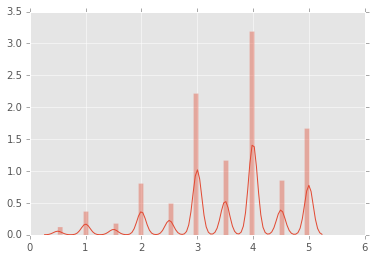

In [19]:
#plot histogram of all ratings
plt.style.use('ggplot')
dist = ratings_filtered['rating']
sns.distplot(dist)

To continue this exploratory data analysis, we are going to make use of a new tool, Tableau. All results are screenshots. We must first combine our two main data sources: movies and ratings_filtered.

In [20]:
#make a master data set for Tableau consumption
master_combined = ratings_filtered.join(movies)
master_combined.export_csv("master_combined.csv")

Joe insert Top 10 PNG Here

One central question we must begin with is what are the most popular films? We calculated this by averaging ratings across all films in our data set and then displaying the top 10 films. This is an important first step as we look toward deployment as a 'phase one' recommendation system could be implemented to merely recommend most popular films. This plot also tells us something interesting in relation to time: 80% of the top ten films were released in the 1990s, with the other two belonging to the Star Wars franchise. This ranking is also indicative of our previously found popular genres, as the two top films, Shawshank Redemption and Shindler's List, could be broadly categorized as drama. Another interesting observation is that many of these films are 'award winning.' As we will see when we get to a word cloud of film tags, "top films" and "best of" are frequent terms. 

In [ ]:
Joe Insert Over Time Rating

While we see that the top rated films are heavily dominated by the 1990s, we also need to understand how ratings change over time. We utilized each film's year of release to plot the average rating of films in each year. What we see is that our viewers tend to favor the classics: movies from the 1950s - 1970s tend to be rated higher than more recent offerings. However, we cannot claim that viewers are only interested in films from those decades, as we saw most of our highly rated films come from the 90s. A majority of years do not have an annual rating of less than three, as supported by the initial histogram of ratings. As we look into the recent past, we do see that films in the 1980s tend to rank higher than films from the 1990s and 2000s. 

In [ ]:
Joe insert ratings by genre

Because we know that our viewers give frequent ratings to comedy and/or drama, we need to understand how ratings vary by genre. As already demonstrated, films can have multiple genres. We are concerning ourselves first with the 'core genres': Action, Adventure, Animation, Children’s, Comedy, Crime, Documentary, Drama, Fantasy, Film-Noir, Horror, Musical, Mystery, Romance, Sci-Fi, Thriller, War, and Western. We see from the plot that while comedy films are associated with frequent ratings, the average rating is 3.2, meaning there are nine other genres associated with higher ratings. One piece of information we can gain from this plot is akin to our purpose of early implemenation with a lack of consumer data: we could also make initial recommendations on popular genres. Genres Mystery/War/Drama films are associated with an high ranking, while action/science-fiction/children films tend to have lower ratings. It is also important to remember we are only attempting to get a very high level view of consumer behavior with this analysis, as films can have a multitude of genres.

In [ ]:
Joe insert genres

Because the genre field is so rich, we now consider every possible combination of genre. We are visualizing all the film genres rated by viewers in this tree map, regardless of rating. This view tells us that the many combinations of comedy/drama/romance are frequent items. The average ratings of these films were not especially low or high, indicating that as a whole, the genre may be a mixed bag of solid film and fluff. We will use the genre field once we get into modeling, as it appears it varies considerably across our users.

In [ ]:
Joe insert dist by year

We do have ratings assigned by users and an associated time stamp. Because of this, we are interested in evaluating consumer behavior has changed over time. For example, are people assigning more '5' ratings in recent years vs. the past? What we see above is a slight change. One thing is consistent: all years contain at least one film with a five rating. However, users around 2003 began rating films lower, as this was the first year with films rated less than one. This is a trend that continues from 2003 - 2016. This may be attributed to simply more data being collected. 

In [ ]:
Joe insert Word Cloud

The tags data set is also worth investigating. If users are passionate about a film, he/she may be more inclined to leave some text about the film. This behavior could be applied to extremely positive or extremely negative feelings toward a certain movie. As such, we are not concluding that these phrases are associated with good or bad film unless obvious such as "buy the DVD." What is likely positive is that we see many instances of "get dvd" and "top list." These type of comments are good candidates to recommend as a first step, especially if we see "top list." Another interesting point is we see TCM (Turner Classic Movies) as a frequent tag. This finding is consistent with the earlier analysis of ratings by year in which we saw average higher ratings in the 1950s-1970s. Other popular tags such as "sci-fi" are associated with lower average ratings. This high-level text analysis can also be used to guide our implementation. For example, we see many instances of "top list." One potential strategy is to recommend/feature award-winning films of recent years. 

Joe insert MS Excel Dist_By_User Chart:1
Joe insert MS Exel Count_of_Reviews Chart :2

One other aspect we need to address before jumping into modeling is to gain an understanding of User IDs and their rating count distribution. 

This will be important when we discuss our metrics. For example, if we have some users with very few ratings, their recommendations are likely suboptimal. On the other hand, users with a multitude of ratings will likely have much better results (lower RMSE). We realize this will be a shortcoming of our implementation and will discuss more in the deployment section. We do see that we have a diverse range of customers; the data set is skewed as seen with a handful of customers logging more than 1,000 ratings. The median user rating count is 71, while the range is 149. 

# Modeling and Evaluation 1

Our ultimate goal of this analysis is to recommend movies users will find insightful. To accomplish this goal, we will evaluate several modeling techniques such as item similarity, factorization, and popularity models. 


To begin, we will first define a common train/test split to accurately benchmark model performance. Our train/test methodology of choice is to perform a random split by user. The process for this technique is, "The test dataset is generated by first choosing max_num_users out of the total number of users in dataset. Then, for each of the chosen test users, a portion of the user’s items (determined by item_test_proportion) is randomly chosen to be included in the test set. This split allows the training data to retain enough information about the users in the testset, so that adequate recommendations can be made. The total number of users in the test set may be fewer than max_num_users if a user was chosen for the test set but none of their items are selected" (https://turi.com/products/create/docs/generated/graphlab.recommender.util.random_split_by_user.html#graphlab.recommender.util.random_split_by_user).

For this analysis, we will use 80% of the data set for training and 20% for testing.

In [22]:
#read in combined data set we used for EDA in Tableau 10.3
data = gl.SFrame.read_csv('master_combined.csv', column_type_hints={"rating":int})

Finished parsing file C:\Users\slcoy\Documents\Data Mining\Project_3\master_combined.csv

Parsing completed. Parsed 100 lines in 0.490301 secs.

Finished parsing file C:\Users\slcoy\Documents\Data Mining\Project_3\master_combined.csv

Parsing completed. Parsed 99958 lines in 0.387023 secs.

In [42]:
#set up train/test split to use across models
train, test = gl.recommender.util.random_split_by_user(data,
                                                    user_id="userId", item_id="title",
                                                    max_num_users=200, random_seed=20,item_test_proportion=0.2)

## Item-Item Models

We begin our modeling approach with evaluating item-item models. Item similarity models, "create a recommender that uses item-item similarities based on users in common" (https://turi.com/products/create/docs/generated/graphlab.recommender.item_similarity_recommender.create.html#graphlab.recommender.item_similarity_recommender.create).


With item similarity models, we will want to evaluate three possibilities of similarity type: cosine, jaccard, and pearson. For these models and others developed, we will recommend 10 items to users. The purpose of this is to think towards implementation. We strive to make our final recommendation system scalable and sensible. Therefore, ten similar items will give users a decent selection without overwhelming.

In [149]:
#set display to ipynb
from IPython.display import display
from IPython.display import Image
gl.canvas.set_target('ipynb')

#generate item similarity model with cosine similarity type
item_item_model_cosine = gl.recommender.item_similarity_recommender.create(train, 
                                  user_id="userId", 
                                  item_id="title", 
                                  target="rating",
                                  only_top_k=10,
                                  similarity_type='cosine')

#generate item similarity model with jaccard similarity type
item_item_model_jaccard = gl.recommender.item_similarity_recommender.create(train, 
                                  user_id="userId", 
                                  item_id="title", 
                                  target="rating",
                                  only_top_k=10,
                                  similarity_type='jaccard')

#generate item similarity model with pearson similarity type
item_item_model_pearson = gl.recommender.item_similarity_recommender.create(train, 
                                  user_id="userId", 
                                  item_id="title", 
                                  target="rating",
                                  only_top_k=10,
                                  similarity_type='pearson')

Recsys training: model = item_similarity

Warning: Ignoring columns movieId, timestamp, genres, genre_list;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 94285 observations with 671 users and 8923 items.

Data prepared in: 0.139367s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 3.01ms                         | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 246.657ms                           | 0                | 0               |

| 998.657ms                           | 100              | 8923            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 1.01269s

Recsys training: model = item_similarity

Warning: Ignoring columns movieId, timestamp, genres, genre_list;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 94285 observations with 671 users and 8923 items.

Data prepared in: 0.245654s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 2.006ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 294.784ms                           | 0                | 0               |

| 898.387ms                           | 100              | 8923            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.910421s

Recsys training: model = item_similarity

Warning: Ignoring columns movieId, timestamp, genres, genre_list;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 94285 observations with 671 users and 8923 items.

Data prepared in: 0.240639s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 5.015ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 451.201ms                           | 0                | 0               |

| 1.45s                               | 87               | 7782            |

| 2.04s                               | 100              | 8923            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 2.06951s

In [96]:
#calculate cosine results using test data
rmse_results_cosine = item_item_model_cosine.evaluate(test)

#calculate jaccard results using test data
rmse_results_jaccard = item_item_model_jaccard.evaluate(test)

#calculate pearson results using test data
rmse_results_pearson = item_item_model_pearson.evaluate(test)


Precision and recall summary statistics by cutoff
+--------+----------------+-----------------+
| cutoff | mean_precision |   mean_recall   |
+--------+----------------+-----------------+
|   1    |      0.36      | 0.0216578362471 |
|   2    |     0.3325     | 0.0437598394819 |
|   3    | 0.326666666667 |  0.062189581044 |
|   4    |    0.31625     | 0.0797962801444 |
|   5    |     0.297      | 0.0892495131312 |
|   6    | 0.294166666667 |  0.106364621682 |
|   7    | 0.278571428571 |  0.116474684946 |
|   8    |    0.27125     |  0.131054188177 |
|   9    | 0.261666666667 |  0.139450482439 |
|   10   |     0.2515     |  0.149151820433 |
+--------+----------------+-----------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 3.6185040349538045)

Per User RMSE (best)
+--------+-------+---------------+
| userId | count |      rmse     |
+--------+-------+---------------+
|   29   |   6   | 2.04878538894 |
+--------+-------+---------------+
[1 rows x 3 columns]


Per User RMSE (worst)

While we will do a deep-dive comparison of models in Modeling and Evaluation 2 and 3, we first want to get a very high-level view of model performance. While we will not make our final recommendation based on 'overall RMSE', it does help us get an understanding of how each model performed on test data. The comparison is below. We will present a more relevant comparison on a per-user basis in upcoming sections. The high-level view of stricly RMSE tells us there is little difference between using Cosine and Jaccard similarity types, while Pearson leads the other in terms of RMSE.

In [98]:
#make summary of model performance
from collections import OrderedDict
summary= OrderedDict([ ('Method', ['Cosine', 'Jaccard', 'Pearson']),
                  ('Overall RMSE', [3.62,3.65,1.15]),
                    ])
item_item_models = pd.DataFrame.from_dict(summary)
item_item_models

,Method,Overall RMSE
0,Cosine,3.62
1,Jaccard,3.65
2,Pearson,1.15


Before advancing to other modeling methods, we will do a quick 'sanity check' on the films recommended. A quick inspection reveals that these results from the Pearson model are not unrealistic. There are more modeling techniques to evaluate; we will now investigate other modeling options. 

In [106]:
#sanity check of item-item model
item_item_results = item_item_model_pearson.get_similar_items(k=10)
results.head()

title,similar,score,rank
Dangerous Minds (1995),Under Siege 2: DarkTerritory (1995) ...,0.400564074516,1
Dangerous Minds (1995),"Net, The (1995)",0.368868887424,2
Dangerous Minds (1995),Copycat (1995),0.352231860161,3
Dumbo (1941),"Jungle Book, The (1967)",0.600221991539,1
Dumbo (1941),Snow White and the SevenDwarfs (1937) ...,0.544793188572,2
Dumbo (1941),Cinderella (1950),0.543803095818,3
Sleepers (1996),Rounders (1998),0.371160924435,1
Sleepers (1996),Ransom (1996),0.353474020958,2
Sleepers (1996),Raising Arizona (1987),0.350268900394,3
Escape from New York(1981) ...,Soylent Green (1973),0.484535515308,1


## Ranking Factorization Model

The next modeling technique we will evaluate is the ranking factorization recommender. This type of model will utilize a user-item matrix. A ranking factorization model will, "create a RankingFactorizationRecommender that learns latent factors for each user and item and uses them to make rating predictions." (https://turi.com/products/create/docs/generated/graphlab.recommender.ranking_factorization_recommender.create.html#graphlab.recommender.ranking_factorization_recommender.create).

This option, within Graphlab, is much better suited for a grid-search of parameters than the item similarity model. Because of this, we begin by searching for the best possible parameters.

In [129]:
#set up grid of parameters
#works consulted https://github.com/eclarson/DataMiningNotebooks/blob/master/13.%20Recommendation%20Systems.ipynb
params = {'user_id': 'userId', 
          'item_id': 'title', 
          'target': 'rating',
          'num_factors': [2, 4, 8, 12, 16, 24, 32, 40], 
          'regularization':[0.0000000001,0.00001,0.0001, 0.001, .01, .1, 1] ,
          'linear_regularization': [0.0000000001, 0.00001,0.0001,0.001, .01, .1, 1]}

#apply grid search to model creation
job = gl.model_parameter_search.create( (train,test),
        gl.recommender.ranking_factorization_recommender.create,
        params,
        max_models=10,
        environment=None)

[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Apr-07-2018-17-14-5600000' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Apr-07-2018-17-14-5600000' scheduled.
[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: A job with name 'Model-Parameter-Search-Apr-07-2018-17-14-5600000' already exists. Renaming the job to 'Model-Parameter-Search-Apr-07-2018-17-14-5600000-84ab1'.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Apr-07-2018-17-14-5600000-84ab1' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Apr-07-2018-17-14-5600000-84ab1' scheduled.


In [133]:
#verify 10 models completed
job.get_status()

{'Canceled': 0, 'Completed': 10, 'Failed': 0, 'Pending': 0, 'Running': 0}

In [134]:
#display best parameters from grid search
best_params = job.get_best_params()
best_params

{'item_id': 'title',
 'linear_regularization': 0.0001,
 'max_iterations': 25,
 'num_factors': 16,
 'num_sampled_negative_examples': 4,
 'ranking_regularization': 0.1,
 'regularization': 0.1,
 'target': 'rating',
 'user_id': 'userId'}

In [136]:
#train model based on best parameters found in grid search
ranking_factorization_model = gl.recommender.ranking_factorization_recommender.create(train, 
                                  user_id="userId", item_id="title", linear_regularization=0.0001,
                                max_iterations = 25, num_factors = 16, num_sampled_negative_examples = 4,
                                ranking_regularization = 0.1, regularization = 0.1, target='rating')                                               

Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 94285 observations with 671 users and 8923 items.

Data prepared in: 0.524394s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 16       |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| ranking_regularization         | Rank-based Regularization Weight                 | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 11785 / 94285 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.00781184        | 1.42731                                  |

| 1       | 0.00390592        | 1.50598                                  |

| 2       | 0.00195296        | 1.56064                                  |

| 3       | 0.00097648        | 1.60085                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00781184        | 1.42731                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 0us          | 1.67898           | 1.10128               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 508.352ms    | 4.34624           | 1.96418               | 0.00781184  |

| 2       | 801.13ms     | 1.46333           | 1.03006               | 0.00781184  |

| 3       | 1.14s        | 1.41821           | 1.01314               | 0.00781184  |

| 4       | 1.44s        | 1.39296           | 1.00226               | 0.00781184  |

| 5       | 1.76s        | 1.37469           | 0.991641              | 0.00781184  |

| 6       | 2.08s        | 1.36032           | 0.984497              | 0.00781184  |

| 10      | 3.16s        | 1.32174           | 0.9642                | 0.00781184  |

| 11      | 3.41s        | 1.31473           | 0.96095               | 0.00781184  |

| 15      | 4.35s        | 1.29292           | 0.948432              | 0.00781184  |

| 20      | 5.53s        | 1.27309           | 0.937634              | 0.00781184  |

| 25      | 6.79s        | 1.25855           | 0.929067              | 0.00781184  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 1.25761

Final training RMSE: 0.927699

In [139]:
#apply test data to ranking factorization model
rmse_results_ranking_factorization = ranking_factorization_model.evaluate(test)
rmse_results


Precision and recall summary statistics by cutoff
+--------+----------------+------------------+
| cutoff | mean_precision |   mean_recall    |
+--------+----------------+------------------+
|   1    |     0.185      | 0.00937289877296 |
|   2    |     0.165      | 0.0164532868854  |
|   3    | 0.163333333333 | 0.0216864287043  |
|   4    |     0.1625     | 0.0277455249424  |
|   5    |     0.154      | 0.0325905181716  |
|   6    |     0.1475     | 0.0385098239009  |
|   7    | 0.142857142857 | 0.0420404998508  |
|   8    |    0.139375    | 0.0460374546018  |
|   9    | 0.131666666667 | 0.0515497977444  |
|   10   |     0.1295     | 0.0584921882976  |
+--------+----------------+------------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 0.975953714307451)

Per User RMSE (best)
+--------+-------+----------------+
| userId | count |      rmse      |
+--------+-------+----------------+
|   24   |   1   | 0.330697683757 |
+--------+-------+----------------+
[1 rows x 3 columns]


Per

{'precision_recall_by_user': Columns:
 	userId	int
 	cutoff	int
 	precision	float
 	recall	float
 	count	int
 
 Rows: 3600
 
 Data:
 +--------+--------+-----------+--------+-------+
 | userId | cutoff | precision | recall | count |
 +--------+--------+-----------+--------+-------+
 |   11   |   1    |    0.0    |  0.0   |   5   |
 |   11   |   2    |    0.0    |  0.0   |   5   |
 |   11   |   3    |    0.0    |  0.0   |   5   |
 |   11   |   4    |    0.0    |  0.0   |   5   |
 |   11   |   5    |    0.0    |  0.0   |   5   |
 |   11   |   6    |    0.0    |  0.0   |   5   |
 |   11   |   7    |    0.0    |  0.0   |   5   |
 |   11   |   8    |    0.0    |  0.0   |   5   |
 |   11   |   9    |    0.0    |  0.0   |   5   |
 |   11   |   10   |    0.0    |  0.0   |   5   |
 +--------+--------+-----------+--------+-------+
 [3600 rows x 5 columns]
 Note: Only the head of the SFrame is printed.
 You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.,
 'precision_

The first thing we notice about this model is that is does improve upon our item-similarity models, beating the best item-similarity (Pearson similarity type) by 15%; the difference between RMSE between the two models is approximately .17. At a high level, this model outperforms the prior three based simply on RMSE. We will take a closer look in sections two and three. As we stated in our exploratory data analysis, we should consider using a popularity modeling technique, as we see certain films with consistent high ratings. We will evaluate this technique next. Before proceeding, we conduct our "sanity check" of recommended films. Nothing in the top ten recommendations is surprising of cause for alarm.

In [157]:
#perform sanity check on ranking factorization
ranking_factorization_sanity = ranking_factorization_model.get_similar_items(k=10)
ranking_factorization_sanity.head()

title,similar,score,rank
Dangerous Minds (1995),Desert Blue (1998),1.0,1
Dangerous Minds (1995),Pirates of the Caribbean:Dead Man's Chest (2006) ...,1.0,2
Dangerous Minds (1995),"Passion of the Christ,The (2004) ...",1.0,3
Dangerous Minds (1995),Midnight Run (1988),1.0,4
Dangerous Minds (1995),"Incredibles, The (2004)",1.0,5
Dangerous Minds (1995),Pay It Forward (2000),1.0,6
Dangerous Minds (1995),"Lost Boys, The (1987)",1.0,7
Dangerous Minds (1995),Supercop 2 (Project S)(Chao ji ji hua) (1993) ...,1.0,8
Dangerous Minds (1995),Teenage Mutant NinjaTurtles (1990) ...,0.999999940395,9
Dangerous Minds (1995),Supercop (Police Story 3:Supercop) (Jing cha gu ...,0.999999940395,10


## Popularity Model

It is hypothesized this type of model will not outperform any of the prior models. However, it is a worthwhile experiment. The popularity model is very similar to the item-similarity model: "[The popularity_model] create(s) a model that makes recommendations using item popularity. When no target column is provided, the popularity is determined by the number of observations involving each item. When a target is provided, popularity is computed using the item’s mean target value. When the target column contains ratings, for example, the model computes the mean rating for each item and uses this to rank items for recommendations"(https://turi.com/products/create/docs/generated/graphlab.recommender.popularity_recommender.create.html#graphlab.recommender.popularity_recommender.create). 

In [144]:
#generate popularity model
popularity_model = gl.recommender.item_similarity_recommender.create(train, 
                                  user_id="userId", 
                                  item_id="title",
                                  target = 'rating')

Recsys training: model = item_similarity

Warning: Ignoring columns movieId, timestamp, genres, genre_list;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 94285 observations with 671 users and 8923 items.

Data prepared in: 0.158421s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 3.008ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 254.678ms                           | 0                | 0               |

| 1.33s                               | 100              | 8923            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 1.36162s

In [145]:
#apply test data to popularity model
rmse_results_popular = popularity_model.evaluate(test)


Precision and recall summary statistics by cutoff
+--------+----------------+-----------------+
| cutoff | mean_precision |   mean_recall   |
+--------+----------------+-----------------+
|   1    |     0.275      | 0.0225150351079 |
|   2    |     0.285      | 0.0417514060772 |
|   3    |      0.28      | 0.0579514730972 |
|   4    |    0.26875     | 0.0715056277448 |
|   5    |     0.265      | 0.0831958413852 |
|   6    | 0.249166666667 |  0.091049246467 |
|   7    | 0.244285714286 |  0.101631000464 |
|   8    |    0.24125     |  0.114144382882 |
|   9    | 0.235555555556 |  0.122503031456 |
|   10   |     0.232      |  0.133470933933 |
+--------+----------------+-----------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 3.6293670180695714)

Per User RMSE (best)
+--------+-------+---------------+
| userId | count |      rmse     |
+--------+-------+---------------+
|   29   |   6   | 2.06712018438 |
+--------+-------+---------------+
[1 rows x 3 columns]


Per User RMSE (worst)

As expected, this model did not outperform the best model developed so far. The overall RMSE is only slightly better than the worst performing item-similarity model (Jaccard): 3.63 vs. 3.65. The 'popularity' model suffers in that it is only recommending 'popular' items, rather than using the user-item matrix as seen in the ranking_factorization model. We have ignored the genre column thus far. We will now take a look at recommending by genre. Just as we have done with past models, we will take a peak at the top ten recommendations to ask ourselves if this model is providing realistic predictions. Nothing below is out of the ordinary.

In [159]:
#perform sanity check on popularity model
popularity_sanity= popularity_model.get_similar_items(k=10)
popularity_sanity.head()

title,similar,score,rank
Dangerous Minds (1995),Under Siege 2: DarkTerritory (1995) ...,0.22807019949,1
Dangerous Minds (1995),"Net, The (1995)",0.212389409542,2
Dangerous Minds (1995),Junior (1994),0.212121188641,3
Dangerous Minds (1995),"Client, The (1994)",0.199999988079,4
Dangerous Minds (1995),Last Action Hero (1993),0.194805204868,5
Dangerous Minds (1995),City Slickers II: TheLegend of Curly's Gold ...,0.190476179123,6
Dangerous Minds (1995),Disclosure (1994),0.186666667461,7
Dangerous Minds (1995),First Knight (1995),0.185714304447,8
Dangerous Minds (1995),"Walk in the Clouds, A(1995) ...",0.175438582897,9
Dangerous Minds (1995),Philadelphia (1993),0.174757301807,10


# Genre Model

The genre feature has largely been ignored. We will now construct an item-similarity model based on genres. Recall that users can input multiple genres per film. It is hypothesized that results could improve if users could only input one genre. Nevertheless, we will revisit the item-similarity template, but will now use genres as our item id. The exploratory data analyis revealed that we do have some popular genres. As such, we hypothesize we can generate a decent model from genre and ratings.

In [152]:
#train an item similarity model for genres
item_item_model_genre = gl.recommender.item_similarity_recommender.create(train, 
                                  user_id="userId", 
                                  item_id="genres", 
                                  target="rating",
                                  only_top_k=10,
                                  similarity_type='pearson')

Recsys training: model = item_similarity

Warning: Ignoring columns movieId, timestamp, title, genre_list;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 94285 observations with 671 users and 896 items.

Data prepared in: 0.140373s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 4.012ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 7.02ms                              | 0                | 0               |

| 325.87ms                            | 100              | 896             |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.340909s

In [154]:
#apply test data to genre model
rmse_results_genre = item_item_model_genre.evaluate(test)


Precision and recall summary statistics by cutoff
+--------+----------------+-------------+
| cutoff | mean_precision | mean_recall |
+--------+----------------+-------------+
|   1    |      0.0       |     0.0     |
|   2    |      0.0       |     0.0     |
|   3    |      0.0       |     0.0     |
|   4    |      0.0       |     0.0     |
|   5    |      0.0       |     0.0     |
|   6    |      0.0       |     0.0     |
|   7    |      0.0       |     0.0     |
|   8    |      0.0       |     0.0     |
|   9    |      0.0       |     0.0     |
|   10   |      0.0       |     0.0     |
+--------+----------------+-------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 1.060342288163208)

Per User RMSE (best)
+--------+-------+----------------+
| userId | count |      rmse      |
+--------+-------+----------------+
|  302   |   6   | 0.399183812026 |
+--------+-------+----------------+
[1 rows x 3 columns]


Per User RMSE (worst)
+--------+-------+---------------+
| userId | count

Again, from a high-level view, we see the overall RMSE is very close to previously developed item-similarity models. The overall RMSE for this model is 1.06, only slightly better than the best performing item-similarity model using Pearson similarity. We do notice that our best genre prediction is for Action/Fantasy/Horror/Romance, while the worst RMSE has a much longer list of genres, supporting our hypothesis that a worthwhile experiment would be to limit genre input for customers to see if we could improve upon this model. As standard operating procedure, we again check the results of our recommender system to see if things look realistic. 

In [161]:
#perform sanity check on genre model
genre_sanity= item_item_model_genre.get_similar_items(k=10)
genre_sanity.head()

genres,similar,score,rank
Drama,Drama|Romance,0.354401111603,1
Drama,Comedy|Drama,0.351566255093,2
Drama,Crime|Drama,0.332672536373,3
Drama,Comedy|Drama|Romance,0.325264275074,4
Drama,Comedy|Romance,0.292306959629,5
Drama,Drama|War,0.275086700916,6
Drama,Drama|Thriller,0.26119363308,7
Drama,Action|Crime|Drama|Thriller ...,0.226917266846,8
Drama,Crime|Drama|Thriller,0.225505173206,9
Drama,Comedy|Drama|Musical|Romance ...,0.22091460228,10


We now have six models to compare: item_item_cosine, item_item_jaccard, item_item_pearson, ranking_factorization, popularity, and genre. While we have been keeping a pulse on model performance, we now will analyze the results for the developed models and make recommendations.

# Modeling and Evaluation 2

We now have six models developed with varying degrees of of high-level performance. We will need to look at some per-user metrics before selecting a final model for deployment. We will first address model comparison of precision and recall. As a review, a per-user recall is defined as "of all the items rated positively by the user, how many did your recommender find?" (https://github.com/eclarson/DataMiningNotebooks/blob/master/13.%20Recommendation%20Systems.ipynb). 

On the other hand, per-user precision is defined as, "of the k items found by your recommender, how many were rated positively by the user?" (https://github.com/eclarson/DataMiningNotebooks/blob/master/13.%20Recommendation%20Systems.ipynb). Because of dispaly issues with the Graphlab library, we will export our precision/recall aggregations as a CSV and then import to see a better view of sorted cutoff values.

In [190]:
#import aggregate function
import graphlab.aggregate as agg

#make a list of summary statistics to aggregate across all models
agg_list = [agg.AVG('precision'),agg.STD('precision'),agg.AVG('recall'),agg.STD('recall')]

#aggregate model peformance statistics for precision-recall comparsison
item_item_cosine_agg = rmse_results_cosine['precision_recall_by_user'].groupby('cutoff',agg_list)
item_item_jaccard_agg = rmse_results_jaccard['precision_recall_by_user'].groupby('cutoff',agg_list)
item_item_pearson_agg = rmse_results_pearson['precision_recall_by_user'].groupby('cutoff',agg_list)
ranking_factorization_agg = rmse_results_ranking_factorization['precision_recall_by_user'].groupby('cutoff',agg_list)
popularity_agg = rmse_results_popular['precision_recall_by_user'].groupby('cutoff',agg_list)
genre_agg = rmse_results_genre['precision_recall_by_user'].groupby('cutoff',agg_list)

#Export models as CSV for precision-recall comparison
item_item_cosine_agg.export_csv("cosine.csv")
item_item_jaccard_agg.export_csv("jaccard.csv")
item_item_pearson_agg.export_csv("pearson.csv")
ranking_factorization_agg.export_csv("ranking.csv")
popularity_agg.export_csv("pop.csv")
genre_agg.export_csv("genre.csv")

#read in model aggregations for precision-recall comparison
cos_import = pd.read_csv("cosine.csv")
jac_import = pd.read_csv("jaccard.csv")
pear_import = pd.read_csv("pearson.csv")
rankg_import = pd.read_csv("ranking.csv")
pop_import = pd.read_csv("pop.csv")
genre_import = pd.read_csv("genre.csv")

#sort data frames for precision-recall comparison
cos_sort = cos_import.sort_values(by=['cutoff'])
jac_sort = jac_import.sort_values(by=['cutoff'])
pear_sort = pear_import.sort_values(by=['cutoff'])
rank_sort = rankg_import.sort_values(by=['cutoff'])
pop_sort = pop_import.sort_values(by=['cutoff'])
genre_sort = genre_import.sort_values(by=['cutoff'])

Now that we have properly compiled the model performance, let's take a look at the precision-recall by user. We are interested in finding the intersection between the precision and recall curves. We will first compare numerically, followed by a visualization comparing models. 

### Item Similarity Model: Cosine

In [258]:
#print out the precision-recall aggregation table
cos_sort

,cutoff,Avg of precision,Stdv of precision,Avg of recall,Stdv of recall
11,1,0.360000,0.480000,0.021658,0.047370
1,2,0.332500,0.381699,0.043760,0.092912
10,3,0.326667,0.346346,0.062190,0.109194
9,4,0.316250,0.305652,0.079796,0.124467
6,5,0.297000,0.274210,0.089249,0.126404
16,6,0.294167,0.258724,0.106365,0.135016
15,7,0.278571,0.245677,0.116475,0.141197
5,8,0.271250,0.235223,0.131054,0.156678
14,9,0.261667,0.231180,0.139450,0.161232
13,10,0.251500,0.219995,0.149152,0.170789


The above item-item model has a decent per-user precision recall. The intersection of both average precision and average recall is  approximately 16. This will become more obvious once we plot the visuals. We can interpret this to mean that on avearage, of all the items rated positively by the user, 19.28% were returned by this model (recall where k = 16). Likewise, of the k-items returned (k=16), 21.46% were rated positively by the user. These results provide a good starting point. However, they are only one side of the equation. We will address the other side (RMSE), in a future section. 

### Item Similarity Model: Jaccard

In [259]:
#print out the precision-recall aggregation table
jac_sort

,cutoff,Avg of precision,Stdv of precision,Avg of recall,Stdv of recall
11,1,0.325000,0.468375,0.027010,0.085150
1,2,0.315000,0.361628,0.043376,0.094443
10,3,0.300000,0.314466,0.059049,0.101407
9,4,0.292500,0.293801,0.072931,0.110697
6,5,0.274000,0.270784,0.083078,0.120916
16,6,0.267500,0.252156,0.095814,0.128429
15,7,0.254286,0.238687,0.107355,0.138332
5,8,0.245625,0.230617,0.119645,0.153937
14,9,0.233889,0.219257,0.126363,0.163115
13,10,0.230000,0.214942,0.136484,0.171138


As expected, the item-similarity model using Jaccard similarity is not significantly different than the prior 'Cosine' model. We see a similar cutoff where the models intersect. The average recall at k=16 is 18.77% and 20.18 for precision. The Jaccard model doesn't offer us any benefit on these metrics. However, we will hold off on final recommendations until RMSE is addressed.

### Item Similarity Model Pearson

In [260]:
#print out the precision-recall aggregation table
pear_sort

,cutoff,Avg of precision,Stdv of precision,Avg of recall,Stdv of recall
11,1,0.000000,0.000000,0.000000,0.000000
1,2,0.000000,0.000000,0.000000,0.000000
10,3,0.000000,0.000000,0.000000,0.000000
9,4,0.000000,0.000000,0.000000,0.000000
6,5,0.000000,0.000000,0.000000,0.000000
16,6,0.000833,0.011756,0.000037,0.000526
15,7,0.000714,0.010076,0.000037,0.000526
5,8,0.000625,0.008817,0.000037,0.000526
14,9,0.000556,0.007837,0.000037,0.000526
13,10,0.001000,0.009950,0.000067,0.000675


The Pearson model does not produce impressive precision-recall results. While we saw a low overall RMSE, the precision-recall is not optimal. The cutoff (k=46) produces an average recall of 0.00023 and an average precision of 0.00033. This model, while a worthwhile experiment, does not offer us anything in terms of average precision or recall.

### Ranking Factorization Model

In [261]:
#print out the precision-recall aggregation table
rank_sort

,cutoff,Avg of precision,Stdv of precision,Avg of recall,Stdv of recall
11,1,0.185000,0.388298,0.009373,0.031126
1,2,0.165000,0.287706,0.016453,0.039946
10,3,0.163333,0.258177,0.021686,0.048669
9,4,0.162500,0.240767,0.027745,0.052516
6,5,0.154000,0.223347,0.032590,0.055609
16,6,0.147500,0.208285,0.038510,0.063783
15,7,0.142857,0.201018,0.042040,0.065329
5,8,0.139375,0.188405,0.046038,0.065946
14,9,0.131667,0.171801,0.051550,0.071115
13,10,0.129500,0.159937,0.058492,0.073462


The Ranking Factorization, recall, had an impressive overall RMSE. The average precision-recall of this model is not as impressive as the Cosine or Jaccard models, but is still 'passable.' We see that point of intersection is again (approximately) k=16, with an average recall of 7.66% and an average precision of 10.31%. Stated differently, of all the items rated positively by the user, 7.66% were returned by the recommender. On a related note, of the k-items returned (k=16), 10.31% were rated by the user. Because this is on a per-user basis, we will keep this model 'in the running' and only make a final decision once RMSE has been evaluated. 

### Popularity Model

In [262]:
#print out the precision-recall aggregation table
pop_sort 

,cutoff,Avg of precision,Stdv of precision,Avg of recall,Stdv of recall
11,1,0.275000,0.446514,0.022515,0.082929
1,2,0.285000,0.348246,0.041751,0.095305
10,3,0.280000,0.308113,0.057951,0.108104
9,4,0.268750,0.270344,0.071506,0.113058
6,5,0.265000,0.263011,0.083196,0.121671
16,6,0.249167,0.249999,0.091049,0.127701
15,7,0.244286,0.243943,0.101631,0.133222
5,8,0.241250,0.236349,0.114144,0.142639
14,9,0.235556,0.227591,0.122503,0.144931
13,10,0.232000,0.218119,0.133471,0.151430


The popularity model, while similar to the item-item models, performs at a similar level in terms of precision-recall. The downside, however, is that the intersection of precision-recall occurs at cutoff 21 (approximately). This model, while similar in performance, is being considered because of what we learned in our exploratory data analysis in Tableau. Recall that we hypothesized that many users of our service would have no ratings. For these customers, starting them off with a popularity based model might prove to be a realistic alternative in cases of missing data. 

### Genre Model

In [263]:
#print out the precision-recall aggregation table
genre_sort

,cutoff,Avg of precision,Stdv of precision,Avg of recall,Stdv of recall
11,1,0.000000,0.000000,0.000000,0.000000
1,2,0.000000,0.000000,0.000000,0.000000
10,3,0.000000,0.000000,0.000000,0.000000
9,4,0.000000,0.000000,0.000000,0.000000
6,5,0.000000,0.000000,0.000000,0.000000
16,6,0.000000,0.000000,0.000000,0.000000
15,7,0.000000,0.000000,0.000000,0.000000
5,8,0.000000,0.000000,0.000000,0.000000
14,9,0.000000,0.000000,0.000000,0.000000
13,10,0.000000,0.000000,0.000000,0.000000


The genre model, while a worthwhile experiment, is not offering us any improvements in precision-recall. This is likely due to the ability of users to input more than one genre, resulting in a large factorial of possibilities. The average precision / average recall occurs at the intersection of cutoff 46 with precision equal to .012 and recall equal to .03. We can conclude this model is suboptimal, but is a candidate for a future experiment: if users could input only one genre, this model could be evaluated at a future point.

Up to this point, we have mainly discussed precision/recall by their numerical values. Let's now turn our attention to a visual of our developed models. Before beginning, recall that the 'best' average precision/recall is associated with the item-similarity model using Cosine similarity type, with a runner-up being the ranking factorization model.

In [265]:
#set up model comparison
model_comp = gl.compare(test, [item_item_model_cosine, item_item_model_jaccard, item_item_model_pearson,
                                 ranking_factorization_model, popularity_model,item_item_model_genre
])

#display visual of model comparsion of precision/recall
gl.show_comparison(model_comp, [item_item_model_cosine, item_item_model_jaccard, item_item_model_pearson,
                               ranking_factorization_model, popularity_model, item_item_model_genre ])

PROGRESS: Evaluate model M0

Precision and recall summary statistics by cutoff
+--------+----------------+-----------------+
| cutoff | mean_precision |   mean_recall   |
+--------+----------------+-----------------+
|   1    |      0.36      | 0.0216578362471 |
|   2    |     0.3325     | 0.0437598394819 |
|   3    | 0.326666666667 |  0.062189581044 |
|   4    |    0.31625     | 0.0797962801444 |
|   5    |     0.296      |  0.089121308003 |
|   6    | 0.293333333333 |  0.106197955016 |
|   7    | 0.277857142857 |  0.116308018279 |
|   8    |    0.27125     |  0.131006569129 |
|   9    | 0.262777777778 |  0.139604012817 |
|   10   |     0.2525     |  0.149219371974 |
+--------+----------------+-----------------+
[10 rows x 3 columns]

PROGRESS: Evaluate model M1

Precision and recall summary statistics by cutoff
+--------+----------------+-----------------+
| cutoff | mean_precision |   mean_recall   |
+--------+----------------+-----------------+
|   1    |     0.325      | 0.0270095

Joe Insert image model_comparison_precision_recall.PNG

The above model comparison tells us the clear winners in terms of precision-recall are two item-similarity models (cosine, jaccard) and the popularity model. As we've iterated, the final model will need to demonstrate strength in both precision/recall, as well as per-user RMSE. We will now address per-user RMSE.

### RMSE Comparison

Given that we now have a better understanding of precision-recall by user, let's not forget our other highly important metric: RMSE. In the past, we looked at 'overall RMSE.' However, this is misleading. We need to get an understanding of the distribution of RMSE. We will use some summary statistics of RMSE of each model to understand this better. Once we get to model visualizations, we will plot histograms to better represent this metric. 

In [266]:
#create summary statistics of RMSE by model
ranking_factorization_rmse = rmse_results_ranking_factorization['rmse_by_user']
rf_min = ranking_factorization_rmse['rmse'].min()
rf_max = ranking_factorization_rmse['rmse'].max()
rf_avg = ranking_factorization_rmse['rmse'].mean()

cos_rmse = rmse_results_cosine['rmse_by_user']
cos_min = cos_rmse['rmse'].min()
cos_max = cos_rmse['rmse'].max()
cos_avg = cos_rmse['rmse'].mean()

jac_rmse = rmse_results_jaccard['rmse_by_user']
jac_min = jac_rmse ['rmse'].min()
jac_max = jac_rmse ['rmse'].max()
jac_avg = jac_rmse ['rmse'].mean()

pear_rmse = rmse_results_pearson['rmse_by_user']
pear_min = pear_rmse['rmse'].min()
pear_max = pear_rmse['rmse'].max()
pear_avg = pear_rmse['rmse'].mean()

pop_rmse = rmse_results_popular['rmse_by_user']
pop_min = pop_rmse['rmse'].min()
pop_max = pop_rmse['rmse'].max()
pop_avg = pop_rmse['rmse'].mean()

gen_rmse = rmse_results_genre['rmse_by_user']
gen_min = gen_rmse ['rmse'].min()
gen_max = gen_rmse ['rmse'].max()
gen_avg = gen_rmse ['rmse'].mean()

#create rmse summary table
rmse_summary= OrderedDict([ ('Method/Statistic', ['Ranking Factorization Mean RMSE','Ranking Factorization MIN RMSE', 'Ranking Factorization MAX RMSE',
                                       'Cosine Mean RMSE', 'Cosine MIN RMSE', 'Cosine MAX RMSE', 'Jaccard Mean RMSE',
                                       'Jaccard MIN RMSE', 'Jaccard MAX RMSE', 'Pearson Mean RMSE', 'Pearson MIN RMSE', 'Pearson MAX RMSE',
                                       'Popularity Mean RMSE', 'Popularity MIN RMSE', 'Popularity MAX RMSE', 'Genre Mean RMSE',
                                       'Genre MIN RMSE', 'Genre MAX RMSE']),
                  ('RMSE Value', [rf_avg,rf_min,rf_max, cos_avg, cos_min, cos_max, jac_avg, jac_min, jac_max, pear_avg,
                                 pear_min, pear_max, pop_avg, pop_min, pop_max, gen_avg, gen_min, gen_max]),
                    ])

#Take RMSE summary into pandas data frame
RMSE_Summary_Table = pd.DataFrame.from_dict(rmse_summary)
RMSE_Summary_Table

,Method/Statistic,RMSE Value
0,Ranking Factorization Mean RMSE,0.957945
1,Ranking Factorization MIN RMSE,0.330698
2,Ranking Factorization MAX RMSE,2.261164
3,Cosine Mean RMSE,3.618162
4,Cosine MIN RMSE,2.048785
5,Cosine MAX RMSE,4.751635
6,Jaccard Mean RMSE,3.685340
7,Jaccard MIN RMSE,2.074115
8,Jaccard MAX RMSE,4.885745
9,Pearson Mean RMSE,1.038356


While we have not actually plotted any distributions yet, we do see some interesting relationships just evaluating the above three-number summary of each model. The first point of interest is that in the previous section, the item-similarity models did well on the precision-recall metrics. However, notice now that Cosine has an average RMSE of 3.62, Jaccard equals 3.69, and Pearson equals 1.03. The popularity model has a similar operating regime with an average RMSE of 3.65. All of the aforementioned models demonstrated a suboptimal RMSE score. The interpretation of this is statistic is simple. The unit of measure can be thought as "stars" in ratings. Stated differently, the Cosine, Jaccard, and Popularity models would be off by at least three stars on average. As we look toward implementation, we see that as a huge problem.

The Pearson and Genre models performed so poorly on precision/recall, they are no longer being considered for a final model. 

The ranking factorization model clearly has an advantage in terms of RMSE: on average the RMSE is less than one, with a best performance equal to .33 and worst case equal to 2.3. The ranking factoization, while not offering the best precision-recall number, clearly has an advantage in RMSE. 

We must also consider the 'worst-case' scenarios of each model (max RMSE). We have not plotted any distributions, so we cannot say how severe of outliers these 'worst-case' scores are, but we can expect them to happen in deployment. Notice that Cosine, Jaccard, and Popularity models have a max RMSE of nearly five. For meaningful recommendations, this is unacceptable. 

Let's now take a look at the distributions of each model.

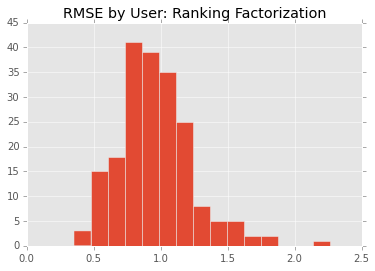

In [281]:
#works consulted: https://github.com/eclarson/DataMiningNotebooks/blob/master/13.%20Recommendation%20Systems.ipynb
#import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

#Look at RMSE by user
rmsevals_rf = rmse_results_ranking_factorization['rmse_by_user']['rmse']
rmsevals_rf = rmsevals_rf[rmse_results_ranking_factorization['rmse_by_user']['count']>1]

#display the plot
plt.hist(rmsevals_rf,bins=15)
plt.title('RMSE by User: Ranking Factorization')
plt.show()

The first thing we notice on the Ranking Factorization model is performs exceptionally well on RMSE when the target is 'user rating.' A majority of the data falls into the RMSE range of less than 1.5. The distribution is approximately normal, indicating that the 'max rmse' of 2.3 is not a regular occurrence. 

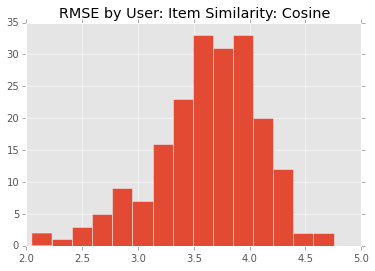

In [286]:
#works consulted: https://github.com/eclarson/DataMiningNotebooks/blob/master/13.%20Recommendation%20Systems.ipynb
#import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

#Look at RMSE by user
rmsevals_cs = rmse_results_cosine['rmse_by_user']['rmse']
rmsevals_cs = rmsevals_cs[rmse_results_cosine['rmse_by_user']['count']>1]

#display the plot
plt.hist(rmsevals_cs,bins=15)
plt.title('RMSE by User: Item Similarity: Cosine')
plt.show()

The item-similarity model using Cosine similarity is not that impressive when we observe performance in terms of RMSE. On average, we can expect a RMSE score of 3.6: not an impressive result. We have serious hesitation selecting this model for final implementation, despite the high precision-recall. 

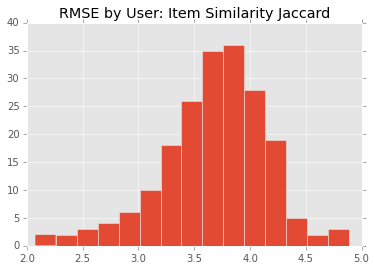

In [287]:
#works consulted: https://github.com/eclarson/DataMiningNotebooks/blob/master/13.%20Recommendation%20Systems.ipynb
#import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

#Look at RMSE by user
rmsevals_jac = rmse_results_jaccard['rmse_by_user']['rmse']
rmsevals_jac = rmsevals_jac[rmse_results_jaccard['rmse_by_user']['count']>1]

#display the plot
plt.hist(rmsevals_jac,bins=15)
plt.title('RMSE by User: Item Similarity Jaccard')
plt.show()

Just as we saw in the Cosine model, the Item Similarity model utilizing Jaccard similarity is not a top-performer. The average RMSE is on par with the Cosine model. For implementation, we cannot expect our customers to get any meaninful recommendations with such a high RMSE. 

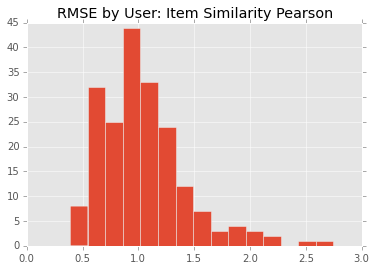

In [288]:
#works consulted: https://github.com/eclarson/DataMiningNotebooks/blob/master/13.%20Recommendation%20Systems.ipynb
#import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

#Look at RMSE by user
rmsevals_pe = rmse_results_pearson['rmse_by_user']['rmse']
rmsevals_pe = rmsevals_pe[rmse_results_pearson['rmse_by_user']['count']>1]

#display the plot
plt.hist(rmsevals_pe,bins=15)
plt.title('RMSE by User: Item Similarity Pearson')
plt.show()

The Pearson model, while decent from a RMSE perspective, is not meeting our expectations: to perform exceptionally well on precision/recall and RMSE. Because of this, we cannot accept the Pearson Item-Similarity model. This model does deserve an 'honorable mention' for RMSE with a right-skewed distribution and a very low average RMSE. 

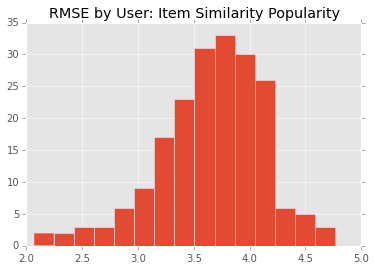

In [289]:
#works consulted: https://github.com/eclarson/DataMiningNotebooks/blob/master/13.%20Recommendation%20Systems.ipynb
#import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

#Look at RMSE by user
rmsevals_pop = rmse_results_popular['rmse_by_user']['rmse']
rmsevals_pop = rmsevals_pop[rmse_results_popular['rmse_by_user']['count']>1]

#display the plot
plt.hist(rmsevals_pop,bins=15)
plt.title('RMSE by User: Item Similarity Popularity')
plt.show()

The popularity demonstrates similar performance to the Jaccard/Cosine models. From an implementation viewpoint, this model will not 'cut it' as a scalable solution because of the high RMSE. However, we should consider using this model if faced with a lack of customer data. This would merely be a way to collect more data and then transition to a more accurate model. 

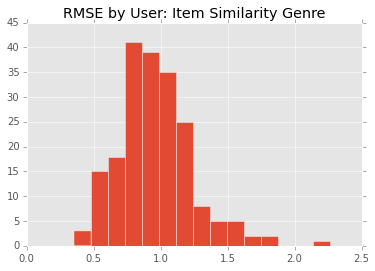

In [290]:
#works consulted: https://github.com/eclarson/DataMiningNotebooks/blob/master/13.%20Recommendation%20Systems.ipynb
#import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

#Look at RMSE by user
rmsevals_gen = rmse_results_genre['rmse_by_user']['rmse']
rmsevals_gen = rmsevals_gen[rmse_results_genre['rmse_by_user']['count']>1]

#display the plot
plt.hist(rmsevals_rf,bins=15)
plt.title('RMSE by User: Item Similarity Genre')
plt.show()

The genre model looks appealing at the RMSE level, but performed very poorly in regards to the precision/recall metric. This model is deceptive, however. The low RMSE could lead one to accept this model as a 'top performer.' However, the precision and recall are both well below our 'hurdle' of acceptance. While we dismiss this model now, it is a notable idea to limit genres in the future with hopes of evaluating a model that recommends films based purely on genre. 

### Final Model Selected

The model that best manages the trade-offs between precision/recall and RMSE is the ranking factorization model. We chose this model for a few reasons. First, the RMSE is impressive and clearly beats all other models from a strict numerical comparison. Second, this approach characterizes users and their films as latent factors. We hypothesize this method better models consumer behavior and provides better rating predictions, as the latent factors likely can predict with better accuracy on less-intuitive films.

We now need to visualize model performance and discuss positive and negative aspects of this model.

# Modeling and Evaluation 3

One aspect of this chosen model we need to evaluate is the items with a low and high RMSE. We do this in order to get a better understanding of where we have room for improvement. For example, if we see certain films with a high RMSE, it will improve our implementation if we can understand why that is happening. 

In [295]:
#save rmse by item and export to CSV for graphing
rmse_by_item = rmse_results_ranking_factorization['rmse_by_item']
rmse_by_item.export_csv("rmse_by_item.csv")

Brian-see what can be done with rmse by item

Other ideas: 

1.)plot standard deviation by cutoff
2.) plot max, min, avg, median by cutoff
3.) count of ratings vs. rmse

# Modeling and Evaluation 4

This model boasts a low RMSE, with an average per-user RMSE of .96 and a per-item average RMSE of .86. This is exceptional performance, especially when compared to other models we constructed during this analysis. With this knowledge of performance, we can make good recommendations and accurate rating predictions. A second benefit of this model is that, with a low RMSE, could lead to more clicks/streams of films. Additionally, if the model can retain a low RMSE over time, we hypothesize it could lead to improved customer retention. A third consequence of applying this model to a production environment is that sales could improve given that we can maintain the performance of this model. We feel that we also have room to grow. First, we have limited data set of films. To accomplish the goals of improved customer retention and improved sales, we will need to cast our net wide to gather more films. The selected model is only our beginning. To provide insightful recommendations, more films are needed. Only by gathering this additional data can we expect to 'move the needle' for revenue. A possible pitfall of any modeling exercise is to become overconfident in performance. We plan to overcome this by first implementing a pilot project in the production environment. This will allow us to make changes, gather more data, and ultimately launch the first evolution of this recommendation system.

We also recognize this model has faults. There are aspects of this model that need to be improved. First, our precision and recall per user is average. On average, we provide a precision of 10-13% and recall between 6-7% if we recommend between 10-16 items. Another shortcoming of this model is that we are not considering geographic/demographic data in our approach. We hypothesize we could improve this model even more by taking this data into account. Another problematic aspect is that we will need to vigilant about updating the films the model recommends. In other words, we cannot leave this model untouched, as new films are released weekly. We will need to develop a process for updating films recommended.

# Deployment

Thomas/Brian

# Exceptional Work

From an exceptional work perspective, we pursued two paths for this project. First, we wanted to explore some new visualization methods not addressed in the course. We learned how to perform our exploratory data analysis using Tableau: see Data Understanding 2 for visuals. We used Tableau 10.3 to accomplish this task. We also learned during the duration of this project that we could publish and track our results with Tableau, which could help explain this concept with business-friendly visuals if tasked with explaining to a business audience.

The second path we pursued for this project is to test out another recommendation Python library. We realize Turi has some shortcomings: Graphlab Create requires an academic license for use. Recommendation systems are typically commercial applications. Thus, a real-world use would require Turi Create. We therefore wanted to research at least one other option. Below, we implement Python’s Surprise library to demonstrate the recommendation landscape is more vast than Turi.